<center>
    
    Vector Output of LSTMs
    
    Author: Daniel Coble
    
    Status: Finished
</center>

An LSTM's complexity is determined by it's 'units'. This is the size of the cell state and hidden states, and an LSTM cell with a larger units number is expected to recognize more complex patterns. But because the output size of the LSTM also has units size (being the hidden state), we often come into the problem that the output has a higher dimension than what we need for our purposes. In fact, often we only want a scalar returned from the LSTM. The common solution to this is to add a dense layer to the top of the model. This works fine, but I suspect a better way to extract a scalar from the vector output of an LSTM would be to simply take the first element of its output.

At first this may seem like it wouldn't work, but remember that the first element of the output is related to every other element through time. What this would seem to allow would be to let the LSTM find features which are relevant but have a nonlinear relationship with the prediction (whereas with a dense top each feature must have a linear relation to the prediction).


In this notebook, I'll train LSTM models on the same dataset used in the "Training an LSTM" notebook: a time series sine wave, with the label being its frequency. I'll train three models, which only vary in the top layer. The first model will be the normal dense top, the second will take only the first element, and the third takes the norm of the output vector.

**TensorFlow 2.5.0 \
Numpy 1.19.5**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from sklearn.metrics import mean_squared_error

def generate_time_series(batch_size, n_steps, y_type = 'period'):
    T = np.random.rand(1, batch_size, 1) * 8 + 2
    phase = np.random.rand(1, batch_size, 1)*2*np.pi
    A = np.random.rand(1, batch_size, 1)*9.8 + .2
    time = np.linspace(0, n_steps, n_steps)
    series = A * np.sin((time - phase)*2*np.pi/T)
    series += 0.1 * (np.random.rand(1, batch_size, n_steps) - .5)
    rtrn = np.expand_dims(np.squeeze(series.astype(np.float32)), axis=2)
    if(y_type == 'amplitude'):
        return rtrn, A.flatten()
    if(y_type == 'frequency'):
        return rtrn, 1/T.flatten()
    if(y_type == 'next_element'):
        return rtrn[:,:,:-1], rtrn[:,:,-1]
    return rtrn, T.flatten()

Now we can train the models for predicting frequency.

In [7]:
# make the models. 2 LSTM layers with 15 units then changing the top. For the first element and norm models, a dense layer 
# used just to scale the result and add a bias (one weight, one bias)
dense_top_model = keras.Sequential((
    keras.layers.LSTM(15, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(15, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(1))
))
first_element_model = keras.Sequential((
    keras.layers.LSTM(15, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(15, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Lambda(keras.layers.Lambda(lambda x: x[:,0:1]))),
    keras.layers.TimeDistributed(keras.layers.Dense(1))
))
norm_vector_model = keras.Sequential((
    keras.layers.LSTM(15, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(15, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Lambda(lambda x: tf.expand_dims(tf.norm(x, axis=1), axis=1))),
    keras.layers.TimeDistributed(keras.layers.Dense(1))
))

models = [dense_top_model, first_element_model, norm_vector_model]

freq_rmse = [0,0,0] # this will fill with RMSE for each model type
freq_val = [] # append validation losses to this list
np.random.seed(42)
n_steps = 75
X, y = generate_time_series(10000, n_steps + 1, y_type='frequency')
X_train = X[:7000]; y_train = y[:7000]
X_test = X[7000:]; y_test = y[7000:]

for i in range(3):
    model = models[i]
    model.compile(
        loss="mse",
        optimizer="adam",
    )
    hist = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=40)
    freq_val.append(hist.history['val_loss'])
    
    pred = model.predict(X_test)[:,-1].flatten()
    rmse = mean_squared_error(y_test, pred, squared=False)
    freq_rmse[i] = rmse

Epoch 1/40
219/219 [==============================] - 9s 33ms/step - loss: 0.0051 - val_loss: 0.0024
Epoch 2/40
219/219 [==============================] - 7s 31ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 3/40
219/219 [==============================] - 7s 30ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 4/40
219/219 [==============================] - 7s 30ms/step - loss: 9.0227e-04 - val_loss: 8.3383e-04
Epoch 5/40
219/219 [==============================] - 6s 30ms/step - loss: 7.7823e-04 - val_loss: 6.7883e-04
Epoch 6/40
219/219 [==============================] - 6s 30ms/step - loss: 6.6687e-04 - val_loss: 6.0235e-04
Epoch 7/40
219/219 [==============================] - 6s 30ms/step - loss: 5.8912e-04 - val_loss: 5.4709e-04
Epoch 8/40
219/219 [==============================] - 7s 30ms/step - loss: 5.4307e-04 - val_loss: 5.0534e-04
Epoch 9/40
219/219 [==============================] - 7s 30ms/step - loss: 5.1833e-04 - val_loss: 5.1212e-04
Epoch 10/40
219/219 [======================

219/219 [==============================] - 8s 35ms/step - loss: 3.1004e-04 - val_loss: 3.0401e-04
Epoch 37/40
219/219 [==============================] - 8s 35ms/step - loss: 3.0804e-04 - val_loss: 3.0139e-04
Epoch 38/40
219/219 [==============================] - 8s 35ms/step - loss: 3.0714e-04 - val_loss: 3.0115e-04
Epoch 39/40
219/219 [==============================] - 8s 35ms/step - loss: 3.0443e-04 - val_loss: 3.0167e-04
Epoch 40/40
219/219 [==============================] - 7s 33ms/step - loss: 3.0205e-04 - val_loss: 2.9632e-04
Epoch 1/40
219/219 [==============================] - 10s 35ms/step - loss: 0.0401 - val_loss: 0.0138
Epoch 2/40
219/219 [==============================] - 8s 35ms/step - loss: 0.0099 - val_loss: 0.0075
Epoch 3/40
219/219 [==============================] - 8s 35ms/step - loss: 0.0062 - val_loss: 0.0050
Epoch 4/40
219/219 [==============================] - 8s 35ms/step - loss: 0.0042 - val_loss: 0.0035
Epoch 5/40
219/219 [==============================] - 7s 

Validation error plots during training for the three models

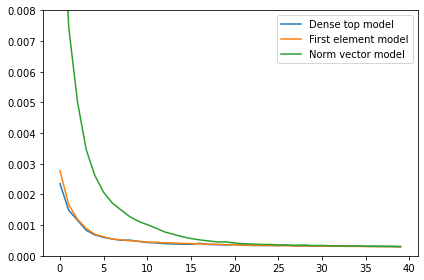

Final loss of dense top model: 0.00029517157236114144
Final loss of first element model: 0.00029632309451699257
Final loss of norm vector model: 0.00030103028984740376


In [17]:
plt.figure()
plt.plot(freq_val[0], label="Dense top model")
plt.plot(freq_val[1], label="First element model")
plt.plot(freq_val[2], label="Norm vector model")
plt.legend()
plt.ylim((0, .008))
plt.tight_layout()
plt.show()

print("Final loss of dense top model: " + str(freq_val[0][-1]))
print("Final loss of first element model: " + str(freq_val[1][-1]))
print("Final loss of norm vector model: " + str(freq_val[2][-1]))

Despite having different convergence rates, the final error of all three models are roughly the same. Therefore it does not seem like the the first element model is more inclined to detect more complex patterns. Also, surprisingly, despite starting with a much higher error, the norm vector model converged to a similar value. I expected that the norm vector model would perform worse, as the model would loose resolution when predicting small values.

Ignoring the modest decrease in the amount of weights, there seems to be little reason to implement first element models. I still like the idea however, because it seems more elegant than the 'hacky' solution of a top layer dense/convolutional cell.

A more thorough analysis of this idea would include varying the sizes of the LSTM cells. Datasets which include time series prediction or other uses of LSTMs could be used. I suspect that norm vector models would perform poorly in datasets which includes labels close to zero.